## Import

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Exploring your data

### Read raw data from file

In [3]:
raw_df = pd.read_csv("../data/crawl/raw_data.csv")
raw_df.head()

,datetime,temp (K),feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds_all,id_weatrher,main_weatrher,description_weatrher,icon_weatrher,rain_1h,wind_gust
0,1.670605e+09,299.16,299.16,1010.0,94.0,299.16,299.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n,NaN,NaN
1,1.670609e+09,299.16,299.16,1009.0,94.0,299.16,299.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n,NaN,NaN
2,1.670612e+09,298.16,299.33,1009.0,100.0,298.16,298.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n,NaN,NaN
3,1.670616e+09,298.16,298.88,1008.0,83.0,298.16,298.16,1.03,20.0,40.0,802.0,Clouds,scattered clouds,03n,NaN,NaN
4,1.670620e+09,298.16,298.88,1008.0,83.0,298.16,298.16,1.03,50.0,40.0,802.0,Clouds,scattered clouds,03n,NaN,NaN


### Checking shape

Checking whenever the data is qualified or not

In [4]:
shape = raw_df.shape

In [5]:
print(f"Shape: {shape}")

if shape[0] > 1000:
    print(f"Data is qualified.")
else:
    print(f"Data isn't qualified")

Shape: (9720, 16)
Data is qualified.


### Dealing with duplicates

In [6]:
num_duplicated_rows = raw_df.duplicated(keep='first').sum()

In [7]:
if num_duplicated_rows == 0:
    print(f"No duplicated lines.")
else:
    ext = "lines" if num_duplicated_rows > 1 else "line"
    print(f"{num_duplicated_rows} duplicated {ext}. De-deduplicating the raw data.")

993 duplicated lines. De-deduplicating the raw data.


In [8]:
# De-deduplicate
raw_df = raw_df.drop_duplicates(keep='first')
post_deduplication_count = raw_df.duplicated(keep='first').sum()
assert post_deduplication_count == 0, "Still have duplicated rows after de-duplication."

In [9]:
# Converting 'datetime' from Unix timestamp to readable datetime format
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'], unit='s')

# Renaming columns
raw_df = raw_df.rename(columns={
    'id_weatrher': 'id_weather',
    'main_weatrher': 'main_weather',
    'description_weatrher': 'description_weather',
    'icon_weatrher': 'icon_weather',
})

missing_values = raw_df.isnull().sum()

data_types = raw_df.dtypes

missing_values, data_types

(datetime                 15
 temp (K)                 15
 feels_like               15
 pressure                 15
 humidity                 15
 temp_min                 15
 temp_max                 15
 wind_speed               15
 wind_deg                 15
 clouds_all               15
 id_weather                1
 main_weather              1
 description_weather       1
 icon_weather              1
 rain_1h                7801
 wind_gust              8612
 dtype: int64,
 datetime               datetime64[ns]
 temp (K)                      float64
 feels_like                    float64
 pressure                      float64
 humidity                      float64
 temp_min                      float64
 temp_max                      float64
 wind_speed                    float64
 wind_deg                      float64
 clouds_all                    float64
 id_weather                    float64
 main_weather                   object
 description_weather            object
 icon_weather 

### Checking distribution

This step helps to understand the Data, detecting outliers, data cleaning and also Model Selection and Performance

For columns with numeric data types:
- Percentage (from 0 to 100) of missing values
- The min
- The lower quartile (phân vị 25)
- The median (phân vị 50)
- The upper quartile (phân vị 75)
- The max

For viewing, using `.round(1)`.

In [10]:
def numeric_column_info(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    num_col_info = {}
    for col in numeric_columns:
        num_col_info[col] = [
            df[col].isnull().mean() * 100,  # Missing ratio
            df[col].min(),                  # Min
            df[col].quantile(0.25),         # Lower quartile
            df[col].median(),               # Median
            df[col].quantile(0.75),         # Upper quartile
            df[col].max()                   # Max
        ]

    # Creating the DataFrame
    num_col_info_df = pd.DataFrame(num_col_info, index=["missing_ratio", "min", "lower_quartile", "median", "upper_quartile", "max"])

    # Rounding values to 1 decimal place
    num_col_info_df = num_col_info_df.round(1)

    return num_col_info_df

In [11]:
num_col_info_df = numeric_column_info(raw_df)

num_col_info_df

,temp (K),feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds_all,id_weather,rain_1h,wind_gust
missing_ratio,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.0,89.4,98.7
min,292.2,292.4,1001.0,14.0,292.2,292.2,0.0,0.0,0.0,200.0,0.1,1.9
lower_quartile,299.2,299.3,1008.0,69.0,299.2,299.2,1.5,10.0,40.0,801.0,0.2,5.3
median,301.2,305.8,1010.0,84.0,301.2,301.2,2.6,160.0,40.0,802.0,0.8,9.8
upper_quartile,304.2,309.6,1011.0,94.0,304.2,304.2,4.1,250.0,75.0,802.0,2.2,12.9
max,311.2,317.2,1018.0,100.0,311.2,311.2,11.3,360.0,100.0,804.0,36.5,20.6


#### Visualizing

Visualize the data to get an easier understanding.

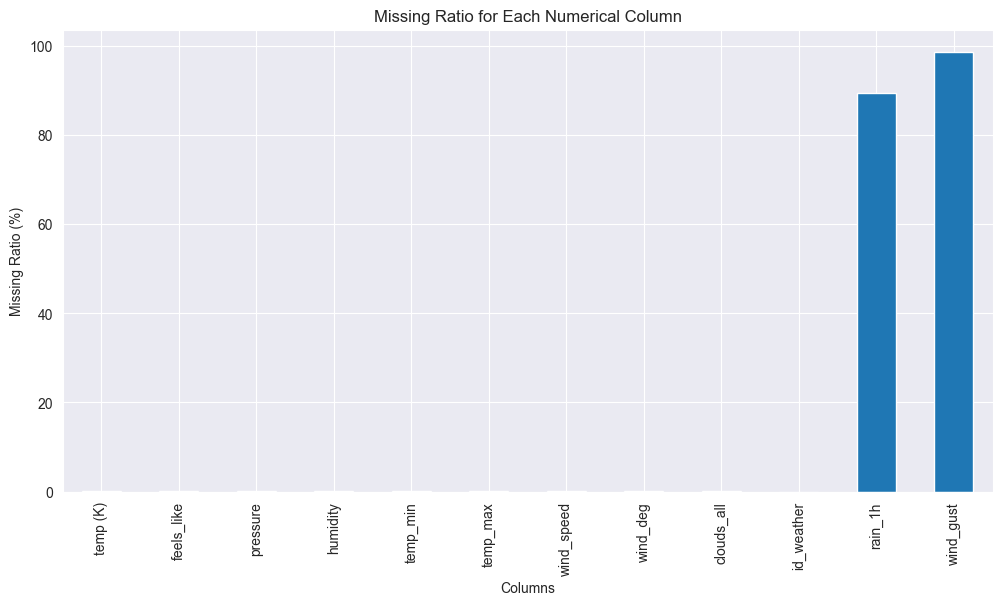

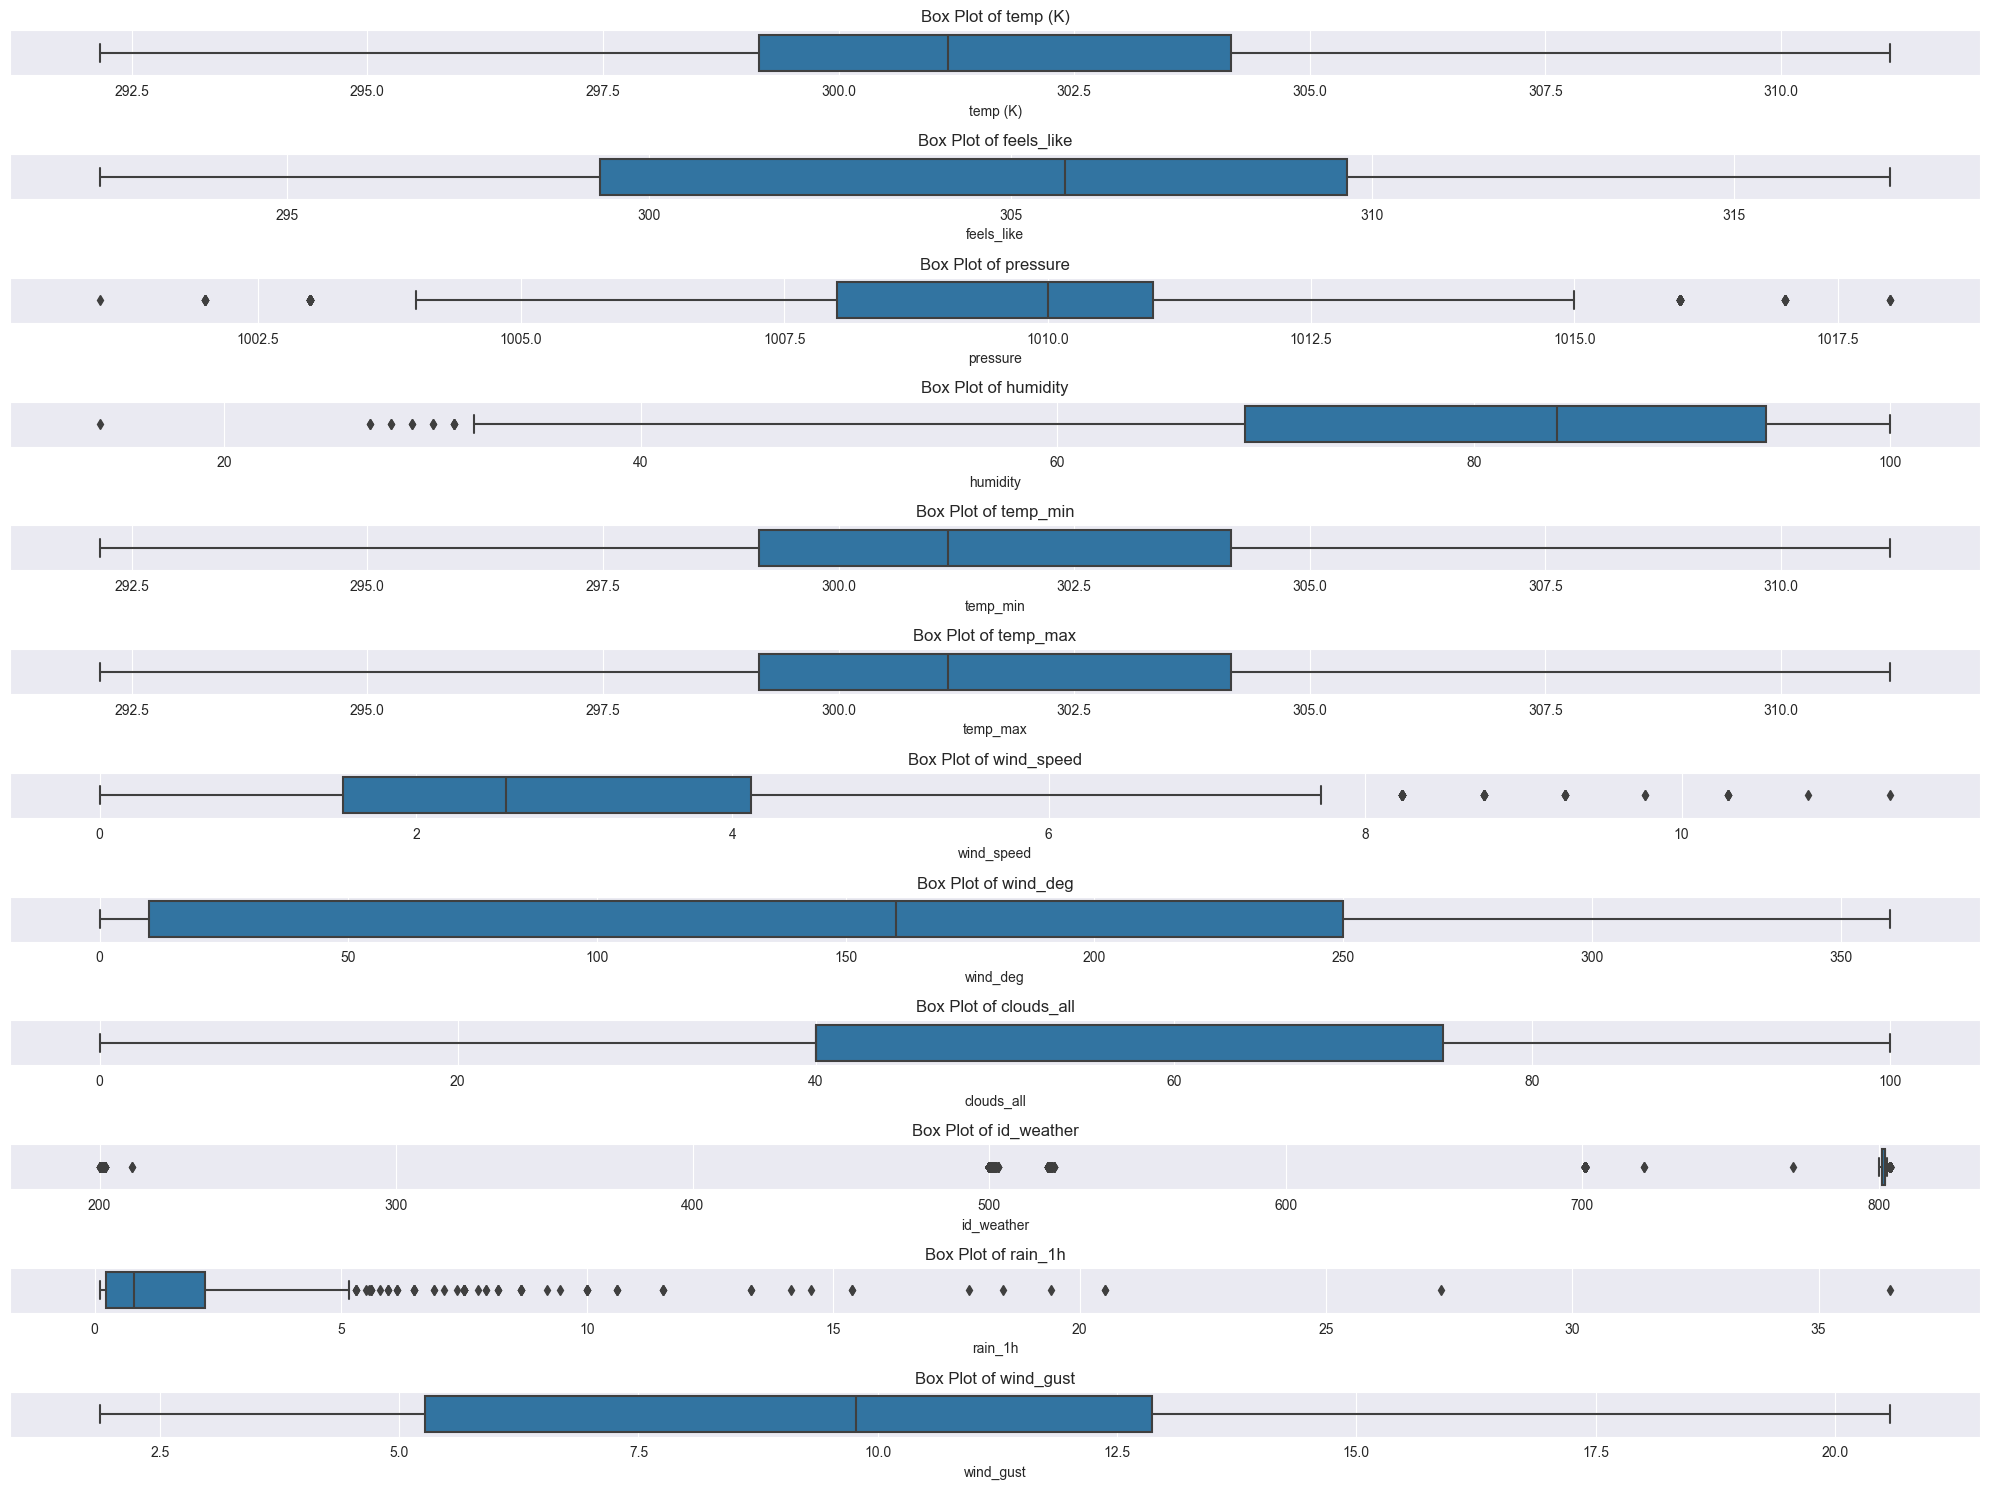

In [12]:
missing_ratio = num_col_info_df.loc['missing_ratio']

# Creating a bar chart for the missing ratio
plt.figure(figsize=(12, 6))
missing_ratio.plot(kind='bar')
plt.title('Missing Ratio for Each Numerical Column')
plt.ylabel('Missing Ratio (%)')
plt.xlabel('Columns')
plt.show()

# Creating box plots for each numerical column
num_cols = raw_df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.boxplot(data=raw_df, x=col)
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [13]:
dict(num_col_info_df.iloc[0])

{'temp (K)': 0.2,
 'feels_like': 0.2,
 'pressure': 0.2,
 'humidity': 0.2,
 'temp_min': 0.2,
 'temp_max': 0.2,
 'wind_speed': 0.2,
 'wind_deg': 0.2,
 'clouds_all': 0.2,
 'id_weather': 0.0,
 'rain_1h': 89.4,
 'wind_gust': 98.7}

In [14]:
def drop_missing_features(df: pd.DataFrame, missing_lst=None, threshold: float = 75.0) -> pd.DataFrame:

    if (df is None) or (missing_lst is None) or (threshold is None):
        print(f"Invalid.")
        raise ValueError
    
    df_cp = df.copy()
    
    cols_to_trim = []
    
    for key, value in missing_lst.items():
        if float(value) > threshold:
            cols_to_trim.append(key)
            
    if len(cols_to_trim) > 0:
        df_cp = df_cp.drop(columns=cols_to_trim)
        print("Dropped column(s): " + " ".join(cols_to_trim))
    else:
        print("Have no column(s) to trim.")
        
    return df_cp

In [15]:
raw_df = drop_missing_features(raw_df, dict(num_col_info_df.iloc[0]))
# Drop columns with no dates
raw_df.dropna(subset=['datetime'], inplace=True)

Dropped column(s): rain_1h wind_gust


In [16]:
raw_df.head()

,datetime,temp (K),feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds_all,id_weather,main_weather,description_weather,icon_weather
0,2022-12-09 17:00:00,299.16,299.16,1010.0,94.0,299.16,299.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n
1,2022-12-09 18:00:00,299.16,299.16,1009.0,94.0,299.16,299.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n
2,2022-12-09 19:00:00,298.16,299.33,1009.0,100.0,298.16,298.16,1.03,0.0,40.0,802.0,Clouds,scattered clouds,03n
3,2022-12-09 20:00:00,298.16,298.88,1008.0,83.0,298.16,298.16,1.03,20.0,40.0,802.0,Clouds,scattered clouds,03n
4,2022-12-09 21:00:00,298.16,298.88,1008.0,83.0,298.16,298.16,1.03,50.0,40.0,802.0,Clouds,scattered clouds,03n


In [17]:
num_col_info_df = numeric_column_info(raw_df)

num_col_info_df

,temp (K),feels_like,pressure,humidity,temp_min,temp_max,wind_speed,wind_deg,clouds_all,id_weather
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,292.2,292.4,1001.0,14.0,292.2,292.2,0.0,0.0,0.0,200.0
lower_quartile,299.2,299.3,1008.0,69.0,299.2,299.2,1.5,10.0,40.0,801.0
median,301.2,305.8,1010.0,84.0,301.2,301.2,2.6,160.0,40.0,802.0
upper_quartile,304.2,309.6,1011.0,94.0,304.2,304.2,4.1,250.0,75.0,802.0
max,311.2,317.2,1018.0,100.0,311.2,311.2,11.3,360.0,100.0,804.0


Skipping filling because there is no missing cells.

For columns with non-numeric data types:
- Percentage (from 0 to 100) of missing values
- Number of values (the values here are different values and we do not consider missing values)
- The percentage (from 0 to 100) of each value is sorted by decreasing percentage (we do not consider missing values, the ratio is the ratio compared to the number of non-missing values)

In [18]:
non_numeric_columns = raw_df.select_dtypes(exclude=['float64']).columns

cat_col_info = {}
for col in non_numeric_columns:
    missing_ratio = raw_df[col].isnull().mean() * 100

    num_values = raw_df[col].nunique()

    value_counts = raw_df[col].value_counts(normalize=True) * 100
    value_ratios = value_counts.to_dict()

    cat_col_info[col] = [missing_ratio, num_values, value_ratios]

cat_col_info_df = pd.DataFrame(cat_col_info, index=["missing_ratio", "num_values", "value_ratios"])

cat_col_info_df.loc['missing_ratio'] = cat_col_info_df.loc['missing_ratio'].apply(lambda x: round(x, 1) if isinstance(x, float) else x)

cat_col_info_df

,datetime,main_weather,description_weather,icon_weather
missing_ratio,0.0,0.0,0.0,0.0
num_values,8712,7,19,16
value_ratios,"{2022-12-09 17:00:00: 0.01147842056932966, 202...","{'Clouds': 85.43388429752066, 'Rain': 9.779614...","{'scattered clouds': 41.976584022038566, 'brok...","{'03n': 22.302571166207528, '03d': 19.67401285..."


### Is the collected data reasonable?

This step is just to check if the data is ok to use.

Range and Value Checks for Numeric Columns
Example ranges:
Temperature in Kelvin (0K is absolute zero, upper limit is less defined but should be reasonable)
Atmospheric pressure in hPa (typical range: 300 to 1100)
Humidity in % (0 to 100)
Wind speed in m/s (no upper limit, but excessively high values may be suspect)
Wind degree (0 to 360)
Cloudiness in % (0 to 100)

In [19]:
temp_range_check = raw_df['temp (K)'].between(0, 350).all()
pressure_range_check = raw_df['pressure'].between(300, 1100).all()
humidity_range_check = raw_df['humidity'].between(0, 100).all()
wind_speed_range_check = raw_df['wind_speed'] >= 0
wind_deg_range_check = raw_df['wind_deg'].between(0, 360).all()
clouds_all_range_check = raw_df['clouds_all'].between(0, 100).all()

# Results
range_check_results = {
    'Temperature (0K-350K)': temp_range_check,
    'Pressure (300hPa-1100hPa)': pressure_range_check,
    'Humidity (0%-100%)': humidity_range_check,
    'Wind Speed (>=0 m/s)': wind_speed_range_check.all(),
    'Wind Degree (0°-360°)': wind_deg_range_check,
    'Cloudiness (0%-100%)': clouds_all_range_check
}

range_check_results

{'Temperature (0K-350K)': True,
 'Pressure (300hPa-1100hPa)': True,
 'Humidity (0%-100%)': True,
 'Wind Speed (>=0 m/s)': True,
 'Wind Degree (0°-360°)': True,
 'Cloudiness (0%-100%)': True}

### Saving

In [20]:
print(f"Total number of features: {raw_df.shape[1]}")
raw_df.dtypes

Total number of features: 14


datetime               datetime64[ns]
temp (K)                      float64
feels_like                    float64
pressure                      float64
humidity                      float64
temp_min                      float64
temp_max                      float64
wind_speed                    float64
wind_deg                      float64
clouds_all                    float64
id_weather                    float64
main_weather                   object
description_weather            object
icon_weather                   object
dtype: object

In [21]:
raw_df.to_csv("../data/processed/processed_data.csv", index=False)